# Michaelis-Menten Model Calibration Example

In [32]:
import numpy as np
import roadrunner
from scipy import io
import pandas as pd
import matplotlib.pyplot as plt
import copy
import math

import pypesto
import pypesto.engine as eng
import pypesto.visualize as visualize
import pypesto.optimize as optimize
import pypesto.profile as profile
import pypesto.sample as sample
import pypesto.store as store
import os 

SEED=12345
np.random.seed(seed=SEED)
engine = eng.SingleCoreEngine()#eng.MultiProcessEngine(n_procs=os.cpu_count())

print(os.cpu_count())

MODEL_SBML_FILE = "model_sbml.xml"
SPECIES = ["S", "E", "ES", "P"]
SPECIES_IDs = ["S1", "S2", "S3", "S4"] # how the species ids are saved in the SBML file from the original BNGL model
SPECIES_COLORS = ["r", "b", "indigo", "g"]
PARAMS = ["log_k1", "log_k2", "log_k3"]

LOG_ERROR = False

4


### Load experimental data used to calibrate model
From here: https://github.com/RuleWorld/ptempest/tree/master/examples/michment

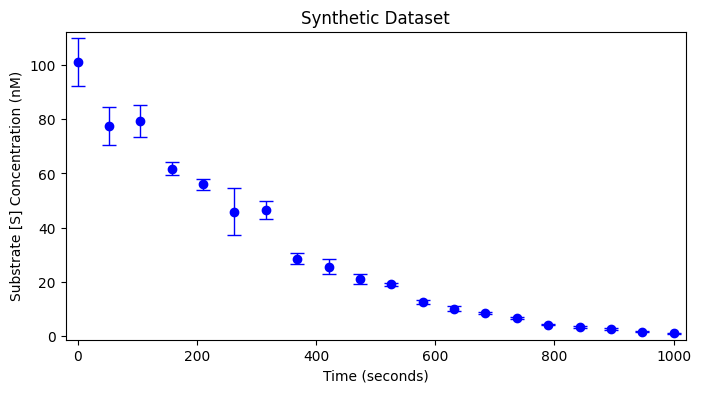

In [33]:
data = io.loadmat("MM.mat")["expt"]
data = data.ravel()[0][0]
data_ts = data["time"][0].flatten()
means = data["mean"][0]
data_means = means[~(pd.isnull(means))]
stds = data["stdev"][0]
data_stds = stds[~(pd.isnull(stds))]
labels = data["obsv_labels"][0][0]
data_labels = [x[0] for x in labels]
init_conds = [data["S0"][0][0][0], data["E0"][0][0][0]]

plt.figure(figsize=(8,4)),
plt.errorbar(data_ts, data_means, yerr=data_stds, capsize=5, c="b", lw=0, marker="o", elinewidth=1);
plt.xlabel("Time (seconds)"); plt.ylabel("Substrate [S] Concentration (nM)");
plt.margins(x=0.02, y=0.02);
plt.title("Synthetic Dataset");

### Load model using `libroadrunner`

In [34]:
rr = roadrunner.RoadRunner(MODEL_SBML_FILE)
rr.integrator.absolute_tolerance = 5e-10
rr.integrator.relative_tolerance = 1e-8
print(rr.model.getGlobalParameterIds())
rr["init([S1])"] = float(init_conds[0]) # change initial substrate concentration
rr["init([S2])"] = float(init_conds[1]) # change initial enzyme concentration

['log_k1', 'log_k2', 'log_k3', 'S', 'E', 'ES', 'P', 'k1', 'k2', 'k3']


### Define helper functions that change model parameters and simulate model

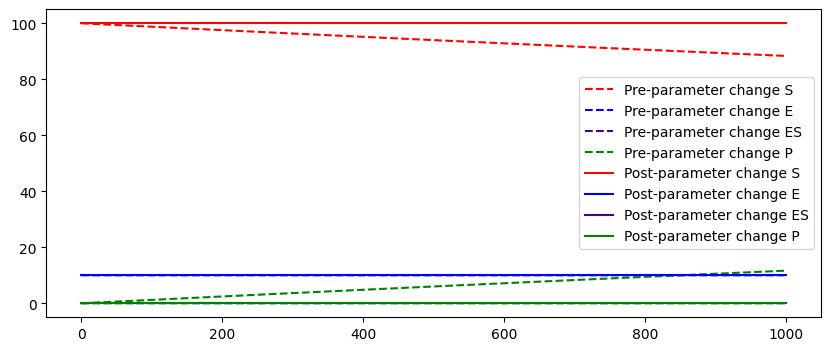

In [35]:
# determine output time points for model based on data time points
step = (len(data_ts)-1)*10
duration = 1000.0

def change_and_run(new_params):
    rr.reset()
    for name,val in zip(PARAMS, new_params):
        #print(name, "PRE-CHANGE IN MODEL: ",  rr[name])
        rr[name] = val
        rr.reset() # This forces assignment rules in the SBML model to be re-evaluated
        #print(name, val, rr[name])
    try:
        res = rr.simulate(0, duration, steps=step)
        #print(res)
    except:
        res = []
    return res

rr.resetAll()
plt.figure(figsize=(10,4))
orig_traj = rr.simulate(0, duration, steps=step)
orig_ts = orig_traj[:, 0]
#print(orig_ts)
orig_specs = np.transpose(orig_traj[:, 1:])
for cur_label, cur_traj, cur_c in zip(SPECIES, orig_specs, SPECIES_COLORS):
    plt.plot(orig_ts, cur_traj, c=cur_c, label="Pre-parameter change %s"%cur_label, linestyle="--")
plt.legend();

# sanity check by setting all parameters to near 0
traj = change_and_run([-10, -10, -10])
traj_ts = traj[:, 0]
traj_specs = np.transpose(traj[:, 1:])

for cur_label, cur_traj, cur_c in zip(SPECIES, traj_specs, SPECIES_COLORS):
    plt.plot(traj_ts, cur_traj, c=cur_c, label="Post-parameter change %s"%cur_label)
plt.legend();

### Define cost function

In [36]:
def cost_fun(params):
    candidate_params = copy.deepcopy(params)    
    guess_res = change_and_run(candidate_params)

    if np.isnan(guess_res).any():
        return np.inf
    
    guess_ts = guess_res[:, 0]
    guess_s = guess_res[:, 1] # substrate 
    #print(guess_ts)
    #print('Data: ', data_ts)
    t_idxs = np.array([i for i in range(len(guess_ts)) for j in range(len(data_ts)) if math.isclose(guess_ts[i],data_ts[j])])
    #print('\n\nT_IDXS: ', t_idxs, '\n', t_idxs.shape[0])
    #print(data_ts.shape[0])
    
    #for g, d in zip(guess_ts, data_ts):
    #print(g, d, g==d, math.isclose(g,d))
    
    if t_idxs.shape[0] != data_ts.shape[0]:
        raise Exception('Not all the times outputted by candidate parameter system are found in data time points! We cannot calculate error!')
    
    guess_s_short = guess_s[t_idxs]
    sse = np.sum(np.square(data_means - guess_s_short) / data_stds)
    
    if LOG_ERROR:
        sse = np.log10(sse)
        
    return sse
    

cost_fun([-1,-1,-1])

7672.917878443158

In [37]:
error = pypesto.Objective(fun=cost_fun)

bnds = np.log10([(1e-5, 1e1), (1e-3, 1e3), (1e-3, 1e3)])
print(bnds)
lb = [x[0] for x in bnds]; ub = [x[1] for x in bnds];
print(ub)
problem = pypesto.Problem(
    objective=error,
    lb=lb,
    ub=ub,
)

[[-5.  1.]
 [-3.  3.]
 [-3.  3.]]
[1.0, 3.0, 3.0]


In [38]:
history_options = pypesto.HistoryOptions(trace_record=True)
optim_nm = optimize.ScipyOptimizer(
    method='Powell', 
    options={'maxiter':int(1e4)}
)

bnd_result = optimize.minimize(
    problem=problem,
    optimizer=optim_nm,
    n_starts=1,
    filename=None, engine=engine,
    progress_bar=True, history_options=history_options
)

100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


<AxesSubplot: title={'center': 'Estimated parameters'}, xlabel='Parameter value', ylabel='Parameter'>

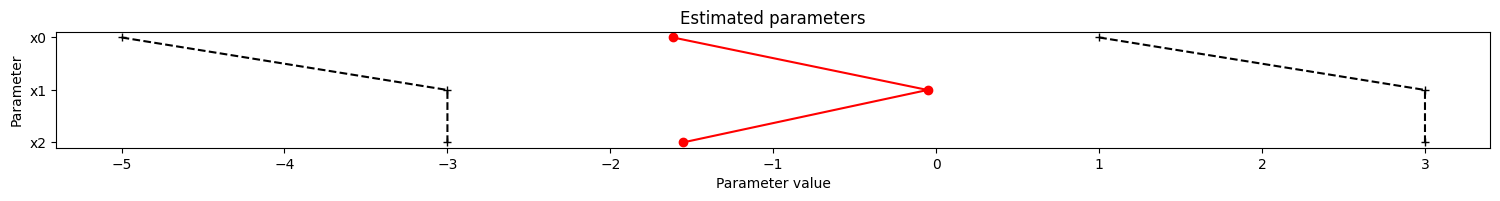

In [39]:
visualize.parameters(bnd_result)

In [40]:
n_samps = 500000
sampler = sample.ParallelTemperingSampler(internal_sampler=sample.MetropolisSampler(), n_chains=3)
bnd_result = sample.sample(
    problem=problem, 
    n_samples=n_samps, 
    result=bnd_result, 
    sampler=sampler,
    filename=None
)
elapsed_time = bnd_result.sample_result.time
print(f"Elapsed time: {round(elapsed_time,2)}")

print(bnd_result.sample_result.keys())
print(bnd_result.sample_result['burn_in'])

100%|██████████| 500000/500000 [1:26:48<00:00, 96.00it/s]  
Elapsed time: 5051.1875


Elapsed time: 5051.19
dict_keys(['trace_x', 'trace_neglogpost', 'trace_neglogprior', 'betas', 'burn_in', 'time', 'auto_correlation', 'effective_sample_size', 'message'])
None


In [44]:
store.write_result(bnd_result, 'mm_test.hdf5', overwrite=True, optimize=False, problem=True, sample=True)